# Предсказание температуры стали

## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

В нашем распоряжении есть данные о режимах нагрева и внесения легирующих добавок, объёмах продуваемого инертного газа, температуре стали на разных этапах для более чем 3000 процессов обработки стали.

## План

- Этап 1. EDA, предобработка данных
    - Обзор содержания таблиц
    - Построение распределений
    - Обработка пропусков, дубликатов и выбросов
    - Поиск взаимосвязи величин (построение диаграммы рассеяния, подсчёт коэф. корреляции)
    - Выбор признаков, подготовка и объединение таблиц для дальнейшей работы
    
    
- Этап 2. Подготовка признаков
    - Отделение целевого признака
    - Разбиение на тестовую и тренировочную-валидационную выборки в соотношении 1:3
    - Исследование признаков на мультиколлинеарность и исключение признаков с высокими значениями VIF
    
    
- Этап 3. Подбор гиперпараметров с кросс-валидацией для следующих моделей машинного обучения
    - Линейная регрессия
    - Случайный лес
    - CatBoost
    - LightGBM
    - XGBoost
    
    
- Этап 4. Тестирование модели 
    - тестирование модели c наименьшей MAE
    - сравнение выбранной модели с константной


- Этап 5. Построение и анализ иерархии важности признаков


- Этап 6. Написание отчёта по проекту

## Этап 1. Исследовательский анализ и предобработка данных

На этом этапе мы 
- посмотрим содержание всех доступных таблиц, 
- построим распределения представленных величин,
- поработаем с пропусками, дубликатами и выбросами, если таковые встретятся,
- попробуем найти закономерности в данных и взамосвязь величин,
- подготовим датафрейм для следующего этапа работы.

NB: Для удобства уже в этой части кода импортируем и установим абсолютно все необходимые для работы библиотеки.

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as ltb
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import joblib
from joblib import dump
from sklearn.dummy import DummyRegressor
import warnings

Теперь приступим непосредственно к EDA.

In [2]:
# импортируем наши датасеты через try-except с компьютера и с сервера
try:
    data_arc = pd.read_csv('data_arc.csv')
    data_bulk = pd.read_csv('data_bulk.csv')
    data_bulk_time = pd.read_csv('data_bulk_time.csv')
    data_gas = pd.read_csv('data_gas.csv')
    data_temp = pd.read_csv('data_temp.csv')
    data_wire = pd.read_csv('data_wire.csv')
    data_wire_time = pd.read_csv('data_wire_time.csv')
except:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

### Таблица с данными об электродах

Сперва создадим две функции, одна будет выводить описание данных и первые строки таблиц, а другая - строить диаграммы распределения, находить процент пропусков. 

In [3]:
# функция, которая будет выводить информацию о таблице и первые строки
def info_head(df):
    print(df.head())
    print(df.info())
    print(df.describe())

In [4]:
# функция, которая будет строить диаграммы распределения, находить процент пропусков
def hist_maker(column, df, name):
    df[column].hist(bins=100, grid=False)
    plt.xlabel(column) 
    plt.ylabel('Число')
    plt.title(name) 
    plt.show()
    print('Процент пропусков:', round(100*df[column].isna().sum()/len(df), 2), '%')

Посмотрим на датафрейм с данными об электродах.

In [5]:
info_head(data_arc) # применяем info_head к датафрейму data_arc

   key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755   

   Реактивная мощность  
0             0.687084  
1             0.520285  
2             0.498805  
3             1.062669  
4             0.414397  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реак

In [6]:
# выодим число уникальных процессов в data_arc
print('Число уникальных процессов:', data_arc['key'].nunique())

Число уникальных процессов: 3214


In [7]:
# выводим число дубликатов
print('Число дубликатов:', data_arc.duplicated().sum())

Число дубликатов: 0


Как мы видим, в таблице предтавленны данные о времени, активной и реактивной мощностях за цикл нагрева, по несколько циклов за процесс. Всего в таблице есть данные о 3214 процессах.

Мощность не может быть отрицательной, попробуем превратить отрицательные значения реактивной мощности в нули.

In [8]:
# сперва считаем, затем обнуляем отрицательные значения и снова считаем
print('Число отрицательных значений в реактивной мощности:', data_arc[data_arc['Реактивная мощность'] < 0]['Реактивная мощность'].count())
data_arc.loc[data_arc.loc[:, 'Реактивная мощность'] < 0, 'Реактивная мощность'] = 0
print('Число отрицательных значений в реактивной мощности после замены на нули:', data_arc[data_arc['Реактивная мощность'] < 0]['Реактивная мощность'].count())

Число отрицательных значений в реактивной мощности: 1
Число отрицательных значений в реактивной мощности после замены на нули: 0


Теперь посмотрим на распределение активной и реактивной мощностей. К сожалению, нам неизвестны единицы, поэтому оставим название "единицы".

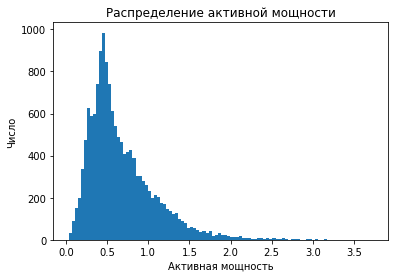

Процент пропусков: 0.0 %


In [9]:
# строим распределение активной мощности
hist_maker('Активная мощность', data_arc, 'Распределение активной мощности')

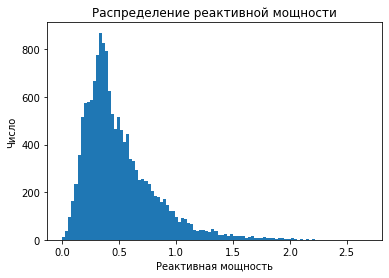

Процент пропусков: 0.0 %


In [10]:
# строим распределение реактивной мощности
hist_maker('Реактивная мощность', data_arc, 'Распределение реактивной мощности')

Активная и реактивная мощности распределены похожим образом, однако вторая несколько сдвинута влево, что логично. Пользуясь данными о длительностях нагрева и активных мощностях, найдём энергию, передаваемую сплаву каждый раз.

Реактивная мощность на состояние системы не влияет, поэтому не будет использовать эти данные в дальнейшем.

In [11]:
# функция перевода timedelta в секунды
def ts(date):
    return date.total_seconds()
# переводим даты в формат datetime
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
# находим разницы и переводим их в секунды
data_arc['Время нагрева'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).apply(ts)
# считаем переданную энергию
data_arc['Переданная энергия'] = data_arc['Время нагрева']*data_arc['Активная мощность']
# выводим первые пять строк таблицы
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева,Переданная энергия
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0,222.541395
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0,149.037310
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0,128.030509
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0,605.667332
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0,102.527702


Посмотрим на зависимость активной мощности и переданной энергии от времени нагрева.

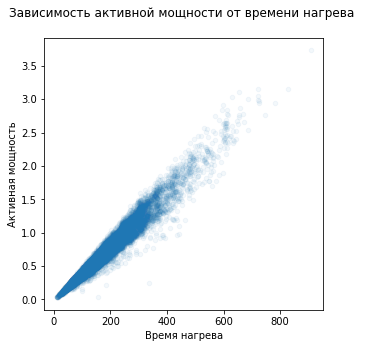

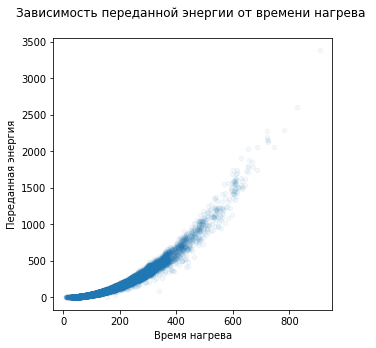

In [12]:
# зависимость активной мощности от времени нагрева
data_arc.plot(x='Время нагрева', y='Активная мощность', kind='scatter', alpha=0.05,  figsize=(5, 5), grid=False)
plt.title('Зависимость активной мощности от времени нагрева \n')
plt.xlabel('Время нагрева')
plt.ylabel('Активная мощность')
plt.show()

# зависимость переданной энергии от времени нагрева
data_arc.plot(x='Время нагрева', y='Переданная энергия', kind='scatter', alpha=0.05,  figsize=(5, 5), grid=False)
plt.title('Зависимость переданной энергии от времени нагрева \n')
plt.xlabel('Время нагрева')
plt.ylabel('Переданная энергия')
plt.show()

В первом случае зависимость линейная, а во втором - квадратичная, что наталкивает на мысль, что активной мощностью в таблице была названа как раз переданная энергия. Думаю, будет правильным просуммировать "активную мощность" в каждом процессе и назвать полученную величину переданной энергией.

Создадим сводную таблицу с числом циклов за процесс, суммами переданной энергии за процесс.

In [13]:
# создаём сводную таблицу
pivot_arc = pd.pivot_table(data_arc, index='key', values=['Активная мощность'], 
                           aggfunc=['count', 'sum'])
pivot_arc.reset_index(inplace=True)
pivot_arc.columns = ['key', 'Число циклов', 'Переданная энергия']
# выводим первые 5 строк
print(pivot_arc.head())

   key  Число циклов  Переданная энергия
0    1             5            4.878147
1    2             4            3.052598
2    3             5            2.525882
3    4             4            3.209250
4    5             4            3.347173


Построим распределения числа циклов нагрева и переданных энергий за процесс.

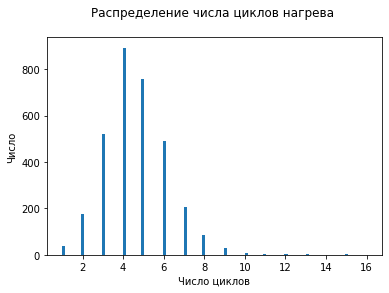

Процент пропусков: 0.0 %


In [14]:
# строим распределение числа циклов нагрева за процесс
hist_maker('Число циклов', pivot_arc, 'Распределение числа циклов нагрева \n')

In [15]:
# выводим варианты числа циклов за процесс
pivot_arc['Число циклов'].unique()

array([ 5,  4,  6,  3,  7, 12, 10, 13,  1,  2,  8,  9, 11, 15, 16, 14])

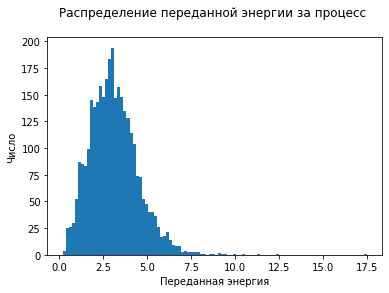

Процент пропусков: 0.0 %


count    3214.000000
mean        3.103138
std         1.397390
min         0.186226
25%         2.126339
50%         2.990537
75%         3.901147
max        17.496497
Name: Переданная энергия, dtype: float64

In [16]:
# строим распределение переданной энергии нагрева за процесс
hist_maker('Переданная энергия', pivot_arc, 'Распределение переданной энергии за процесс \n')
# выводим описание
pivot_arc['Переданная энергия'].describe()

Выведем строчку с максимальным значением энергии.

In [17]:
# строчка с максимальным значением энергии
display(pivot_arc[pivot_arc['Переданная энергия'] == pivot_arc['Переданная энергия'].max()])

,key,Число циклов,Переданная энергия
1672,1689,15,17.496497


Из построенных выше распределений можно сделать вывод, что 
- в процессе может быть от 1 до 16 циклов нагрева, чаще всего 4
- значения переданной энергии распределены нормально, но скошено вправо со медианой 2,99, присутствует один явный выброс, который однако можно объяснить тем, что в процессе целых 15 циклов нагрева 

### Таблицы с данными о сыпучих добавках

Применим функцию info_head к таблице data_bulk.

In [18]:
info_head(data_bulk) # применяем функцию info_head к таблице data_bulk

   key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   

In [19]:
# выводим число уникальных процессов
print('Число уникальных процессов:', data_bulk['key'].nunique())

Число уникальных процессов: 3129


Таблица содержит данные о объёмах добавленния 15 легирующих материалов в 3129 процессах, что на 85 процессов меньше, чем в таблице с данными об электродах. Очевидно, NaN означает, что материал не добавлялся, и должно быть заменено на 0 при подготовке данных.

Посмотрим на рапределения объёмов добавления материалов.

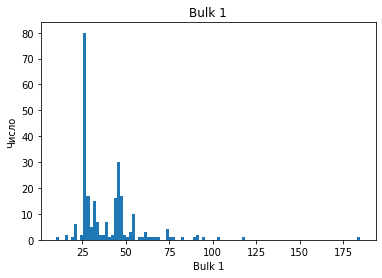

Процент пропусков: 91.95 %


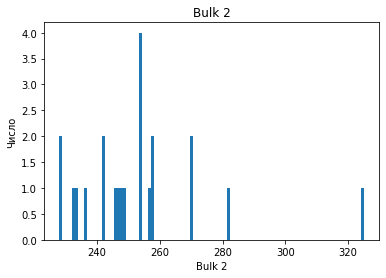

Процент пропусков: 99.3 %


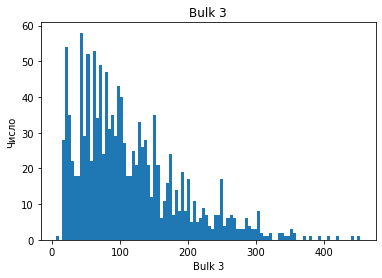

Процент пропусков: 58.52 %


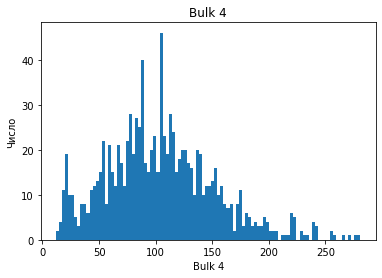

Процент пропусков: 67.59 %


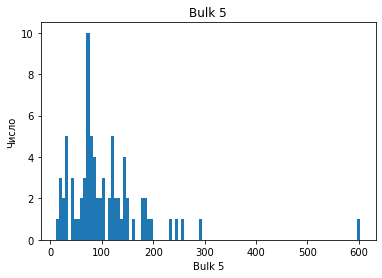

Процент пропусков: 97.54 %


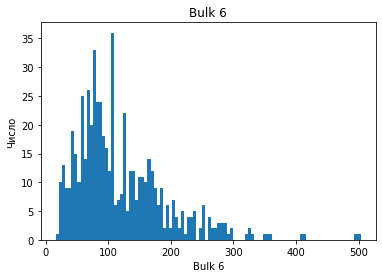

Процент пропусков: 81.59 %


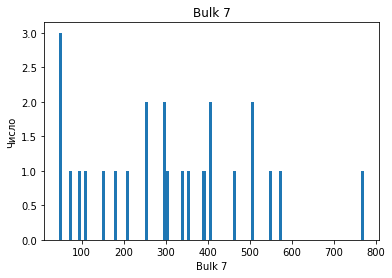

Процент пропусков: 99.2 %


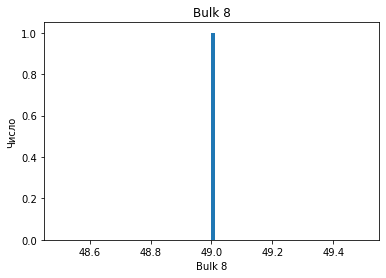

Процент пропусков: 99.97 %


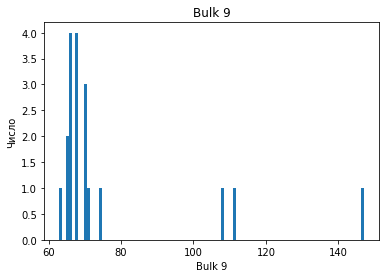

Процент пропусков: 99.39 %


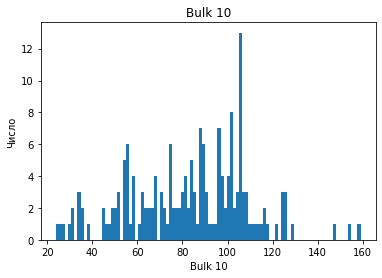

Процент пропусков: 94.38 %


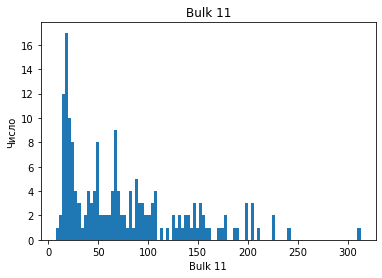

Процент пропусков: 94.34 %


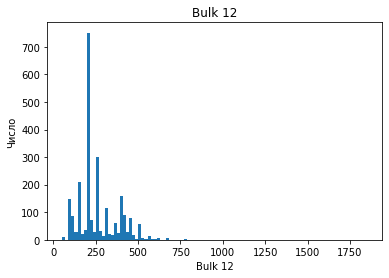

Процент пропусков: 21.7 %


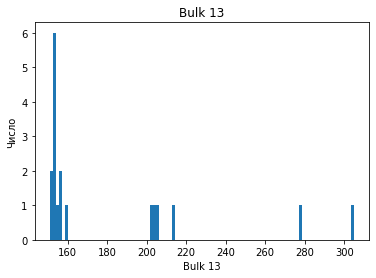

Процент пропусков: 99.42 %


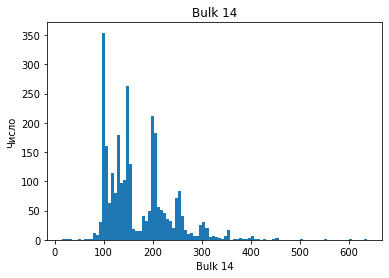

Процент пропусков: 10.32 %


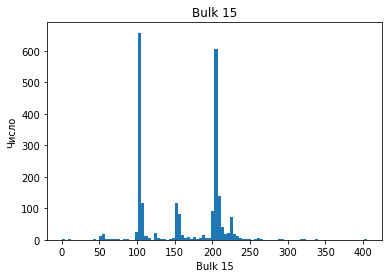

Процент пропусков: 28.16 %


In [20]:
# создаём новую таблицу без номера процесса и строим диаграммы распределения объёмов добавления для каждого материала
data_bulk_no_key = data_bulk.drop(['key'], axis=1)
for column in data_bulk_no_key.columns:
    hist_maker(column, data_bulk_no_key, column)

В таблице присутствуют материалы, которые добавляются в почти 90 % случаев, а есть те, которые добавляются в менее, чем 1 % случаев. Разброс средних объёмов добавления составляет примерно порядок. На некоторых диаграммах (примеси 9, 13, 15) можно выделить несколько отдельных групп пиков, вероятно, они соответствуют разным сортам стали.

Посмотрим на таблицу с временным режимом добавления легирующих материалов.

In [21]:
# применяем функцию info_head к таблице data_bulk_time
info_head(data_bulk_time)

   key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:46:38    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:31:06    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:48:43    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:18:50    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:03:52     NaN  2019-05-03 11:03:52   
1    NaN     NaN     NaN  2019-05-03 11:40:20     NaN  2019-05-03 11:40:20   
2    NaN     NaN     NaN  2019-05-03 12:09:40     NaN  2019-05-03 12:09:40   
3    NaN     NaN     NaN  2019-05-03 12:41:24     NaN  2019-05-03 12:41:24   
4    NaN     NaN     NaN  2019-05-03 13:12:56     NaN  2019-05-03 13:12:56   

               Bulk 15  
0  2019-05-03 11:03:52  


Как видно из этой таблицы, за раз может добавляться как одно вещество, так и несколько

Наконец, посмотрим на корреляцию объёмов добавления различных легирующих материалов.

Теперь заполним пропуски в таблице нулями.

In [22]:
# заполняем пропуски нулями
data_bulk = data_bulk.fillna(0)

In [23]:
# строим таблицу корреляции
data_bulk_no_key = data_bulk.drop(['key'], axis=1)
display(data_bulk_no_key.corr())

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
Bulk 1,1.000000,0.259609,-0.007222,0.050981,0.088394,0.010362,0.257701,-0.004762,-0.020056,-0.026729,-0.037120,0.285582,0.003179,0.183780,0.001814
Bulk 2,0.259609,1.000000,-0.053374,0.043135,0.412000,-0.033091,0.757486,-0.001500,-0.006316,-0.019493,-0.005740,-0.110075,-0.006192,-0.157956,-0.114487
Bulk 3,-0.007222,-0.053374,1.000000,-0.266968,-0.003587,0.073600,-0.043125,0.018249,0.041242,-0.087810,-0.011939,0.008833,-0.007709,0.020869,0.018668
Bulk 4,0.050981,0.043135,-0.266968,1.000000,0.024622,-0.232814,0.045005,-0.010797,-0.004691,-0.078468,-0.115261,0.098192,0.010349,-0.093962,0.111832
Bulk 5,0.088394,0.412000,-0.003587,0.024622,1.000000,-0.003383,0.335044,-0.002252,-0.009483,-0.029270,-0.019058,-0.082443,-0.009297,-0.077825,-0.074282
Bulk 6,0.010362,-0.033091,0.073600,-0.232814,-0.003383,1.000000,-0.029312,-0.007055,-0.029715,-0.091713,0.199409,-0.136876,0.025802,0.199680,-0.101289
Bulk 7,0.257701,0.757486,-0.043125,0.045005,0.335044,-0.029312,1.000000,-0.001367,-0.005757,-0.017769,-0.009379,-0.049310,-0.005644,-0.110137,-0.102531
Bulk 8,-0.004762,-0.001500,0.018249,-0.010797,-0.002252,-0.007055,-0.001367,1.000000,0.425791,-0.004156,-0.003423,-0.024087,-0.001320,-0.033676,-0.024408
Bulk 9,-0.020056,-0.006316,0.041242,-0.004691,-0.009483,-0.029715,-0.005757,0.425791,1.000000,-0.017505,-0.014419,-0.072405,-0.005560,0.035418,-0.096869
Bulk 10,-0.026729,-0.019493,-0.087810,-0.078468,-0.029270,-0.091713,-0.017769,-0.004156,-0.017505,1.000000,-0.044504,0.032095,0.001358,-0.049872,0.058049


<br>Между некоторыми парами добавок (2 и 7, 12 и 15) наблюдается хорошая корреляция. Остальные пары коррелируют умеренно или слабо.

### Таблица с данными о добавках в виде проволоки

Применим функцию info_head к таблице data_wire.

In [24]:
info_head(data_wire) # применяем функцию info_head к таблице data_wire

   key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non

In [25]:
# выводим число уникальных процессов
print('Число уникальных процессов:', data_wire['key'].nunique())

Число уникальных процессов: 3081


Здесь мы видим ещё на 48 процессов меньше. А также то, что, кроме первой и второй добавок, все добавки применялись в менее чем 3 % случаев. 

Посмотрим на рапределения объёмов добавок.

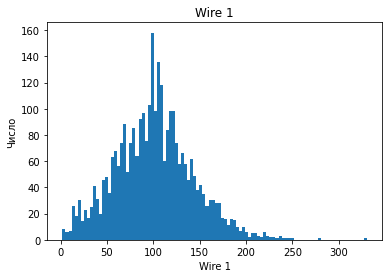

Процент пропусков: 0.84 %


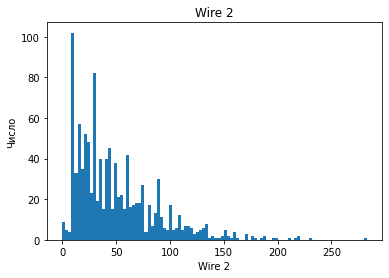

Процент пропусков: 64.98 %


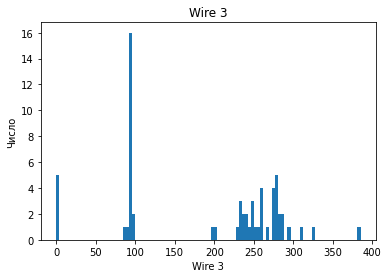

Процент пропусков: 97.96 %


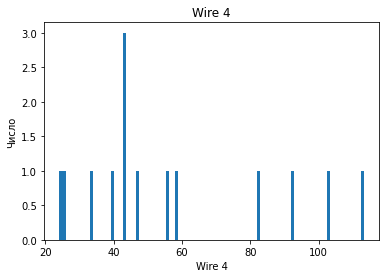

Процент пропусков: 99.55 %


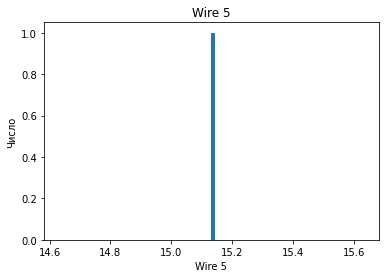

Процент пропусков: 99.97 %


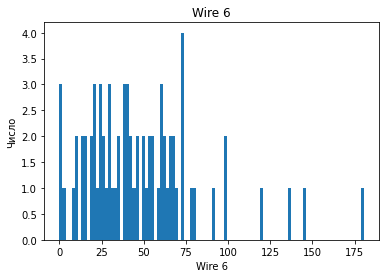

Процент пропусков: 97.63 %


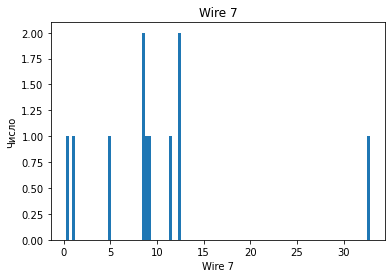

Процент пропусков: 99.64 %


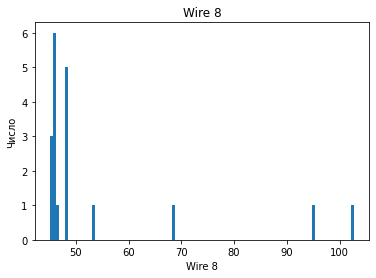

Процент пропусков: 99.38 %


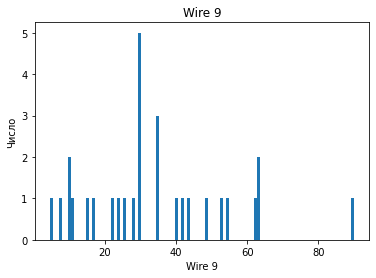

Процент пропусков: 99.06 %


In [26]:
# создаём новую таблицу без номера процесса и строим диаграммы распределения объёмов добавок
data_wire_no_key = data_wire.drop(['key'], axis=1)
for column in data_wire_no_key.columns:
    hist_maker(column, data_wire_no_key, column)

Добавка 1 использовалась в более чем 99 % случаев, объёмы добавления распределены нормально и симметрично. Добавка 2 - примерно в 35 % случаев, наблюдается в основном обратная зависимость между объёмом добавления и числом случаев добавления.

Посмотрим на таблицу с временным режимом добавления.

In [27]:
# применяем функцию info_head к таблице data_wire_time
info_head(data_wire_time)

   key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:11:41                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:46:10                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:13:47                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:48:05                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 

Также видим 3080 записей.

Посмотрим на корреляцию объёмов добавления различных веществ.

In [28]:
# заполняем пропуски нулями
data_wire = data_wire.fillna(0)

Как и в случае с сыпучими добавками, NaN будем считать отсутствием добавки и заполним нулями.

In [29]:
# строим таблицу корреляции
data_wire_no_key = data_wire.drop(['key'], axis=1)
display(data_wire_no_key.corr())

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
Wire 1,1.000000,-0.047824,0.063818,-0.132207,-0.034386,-0.139721,-0.098728,0.025705,0.019411
Wire 2,-0.047824,1.000000,0.143669,-0.032135,-0.009524,-0.064760,-0.024473,0.061162,0.205339
Wire 3,0.063818,0.143669,1.000000,0.150634,0.054946,0.161709,0.126731,-0.009627,-0.010799
Wire 4,-0.132207,-0.032135,0.150634,1.000000,-0.001096,0.386320,0.221907,-0.004578,-0.005135
Wire 5,-0.034386,-0.009524,0.054946,-0.001096,1.000000,0.145189,-0.000834,-0.001357,-0.001522
Wire 6,-0.139721,-0.064760,0.161709,0.386320,0.145189,1.000000,0.269873,-0.009564,-0.010729
Wire 7,-0.098728,-0.024473,0.126731,0.221907,-0.000834,0.269873,1.000000,-0.003486,-0.003911
Wire 8,0.025705,0.061162,-0.009627,-0.004578,-0.001357,-0.009564,-0.003486,1.000000,-0.006360
Wire 9,0.019411,0.205339,-0.010799,-0.005135,-0.001522,-0.010729,-0.003911,-0.006360,1.000000


Заметно коррелируют только примеси 4 и 6.

### Таблица с данными о продувке сплава инертным газом

Применим функцию info_head к таблице data_wire, посмотрим на число уникальных процессов в таблице.

In [30]:
# применим функцию info_head к таблице data_wire
info_head(data_gas)

   key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040


In [31]:
# выводим число уникальных процессов
print('Число уникальных процессов:', data_gas['key'].nunique())

Число уникальных процессов: 3239


Здесь уникальных процессов на 25 больше, чем в таблице с информацией об электродах.

Построим распределение объёмов инертного газа.

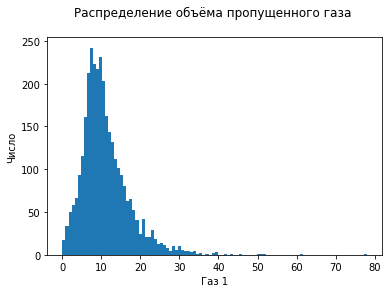

Процент пропусков: 0.0 %


In [32]:
# строим распределение объёмов инертного газа
hist_maker('Газ 1', data_gas, 'Распределение объёма пропущенного газа \n')

В среднем объём равен 11 единицам, со стандартным отклонением 6. Однако есть "хвост" в большую сторону, который доходит аж до 80. 

### Таблица с данными об измерениях температуры сплавов

Применим функцию info_head к таблице data_temp, посмотрим на число уникальных процессов.

In [33]:
info_head(data_temp) # применим функцию info_head к таблице data_temp

   key         Время замера  Температура
0    1  2019-05-03 11:16:18       1571.0
1    1  2019-05-03 11:25:53       1604.0
2    1  2019-05-03 11:29:11       1618.0
3    1  2019-05-03 11:30:01       1601.0
4    1  2019-05-03 11:30:39       1613.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None
                key   Температура
count  15907.000000  13006.000000
mean    1607.880870   1591.840920
std      942.212073     21.375851
min        1.000000   1191.000000
25%      790.000000   1581.000000
50%     1618.000000   1591.000000
75%     2427.000000   1601.000000
max     3241.000000   1705.000000


In [34]:
# выводим число уникальных процессов
print('Число уникальных процессов:', data_temp['key'].nunique())

Число уникальных процессов: 3216


Уникальных процессов на 2 больше, чем в таблице с электродами.

Посмотрим, как у нас распределена температура.

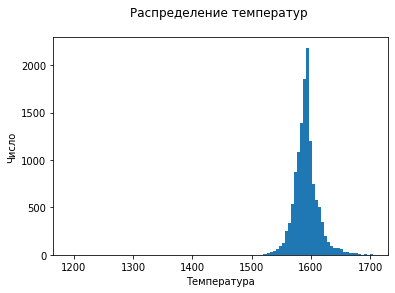

Процент пропусков: 18.24 %


In [35]:
hist_maker('Температура', data_temp, 'Распределение температур \n')

Мы видим симметричное и довольно узкое распределение со средним в 1591 градус. Для построения модели мы будем использовать лишь первую и последнюю температуры. Для этого нам нужно выделить эти данные из общей таблицы с температурами.
Сначала выделим данные о первой температуре.

In [36]:
# создаём таблицу с временем и температурой первого замера
first_time = pd.pivot_table(data_temp, index='key', values='Время замера', 
                           aggfunc='first')
first_time.reset_index(inplace=True)
first_time.columns = ['key', 'Время замера']

first_time_temp = pd.merge(data_temp, first_time, on=['key', 'Время замера'], how='inner')
first_time_temp.columns = ['key', 'Время первого замера', 'Начальная температура']

# выводим информацию о таблице с первым замером
first_time_temp.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    3216 non-null   int64  
 1   Время первого замера   3216 non-null   object 
 2   Начальная температура  3216 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 100.5+ KB


Теперь извлечём данные о конечной температуре.

In [37]:
# создаём таблицу с временем и температурой последнего замера
last_time = pd.pivot_table(data_temp, index='key', values='Время замера', 
                           aggfunc='last')
last_time.reset_index(inplace=True)
last_time.columns = ['key', 'Время замера']

last_time_temp = pd.merge(data_temp, last_time, on=['key', 'Время замера'], how='inner')
last_time_temp.columns = ['key', 'Время последнего замера', 'Конечная температура']

# выводим информацию о таблице с последним замером
last_time_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   key                      3216 non-null   int64  
 1   Время последнего замера  3216 non-null   object 
 2   Конечная температура     2477 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 100.5+ KB


В таблице с данными о последнем замере обнаружено целых 739 пропуска. Это наш целевой признак. Поэтому, к сожалению, придётся удалить данные о почти 23% процессов.

In [38]:
# создаём сводную таблицу со первой и последней температурами за процесс
pivot_temp = pd.merge(first_time_temp, last_time_temp, on=['key'], how='inner')
#удаляем строки с пропуском целевого признака
pivot_temp = pivot_temp.dropna()

На всякий случай избавимся от записей, где совпадают времена первого и последнего замеров. Затем оставляем только колонки с температурами.

In [39]:
# перезаписываем сборную таблицу с температурами, чтобы не было записей с совпадением времени первого и последнего замера
pivot_temp = pivot_temp[pivot_temp['Время первого замера'] != pivot_temp['Время последнего замера']]
pivot_temp = pivot_temp.drop(['Время первого замера', 'Время последнего замера'], axis=1)
# выводим информацию о сборной таблице с температурами 
info_head(pivot_temp)

   key  Начальная температура  Конечная температура
0    1                 1571.0                1613.0
1    2                 1581.0                1602.0
2    3                 1596.0                1599.0
3    4                 1601.0                1625.0
4    5                 1576.0                1602.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2476
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2475 non-null   int64  
 1   Начальная температура  2475 non-null   float64
 2   Конечная температура   2475 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 77.3 KB
None
               key  Начальная температура  Конечная температура
count  2475.000000            2475.000000           2475.000000
mean   1250.787071            1588.402020           1595.336162
std     719.787271              29.243044             16.023153
min       

Построим распределения начальной и конечной температур.

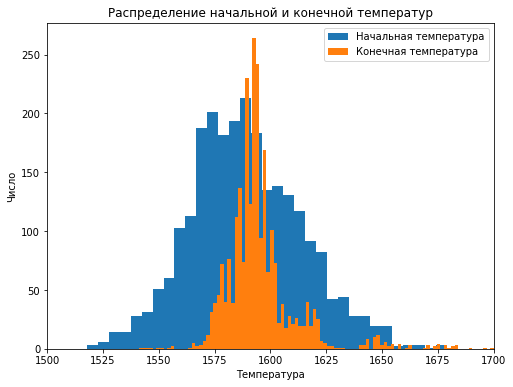

In [40]:
pivot_temp['Начальная температура'].hist(bins=100, grid=False, legend=True, figsize=(8, 6))
pivot_temp['Конечная температура'].hist(bins=100, grid=False, legend=True)
plt.xlabel('Температура') 
plt.ylabel('Число')
plt.xlim(1500, 1700)
plt.title('Распределение начальной и конечной температур') 
plt.show()

Видно, что конечная температура изменяется в значительно более узком диапазоне, чем начальная. Это в принципе видно и по величинам стандартных отклонений - 16 и 29 градусов соответственно.

Теперь посмотрим на зависимость конечной температуры от начальной и коэффициент корреляции между ними.

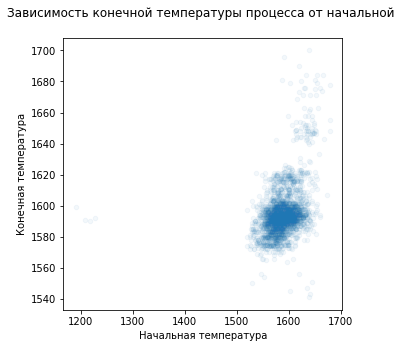

Коэффициент корреляции: 0.37662057864082815


In [41]:
# зависимость конечной температуры процесса от начальной
pivot_temp.plot(x='Начальная температура', y='Конечная температура', kind='scatter', alpha=0.05,  figsize=(5, 5), grid=False)
plt.title('Зависимость конечной температуры процесса от начальной \n')
plt.xlabel('Начальная температура')
plt.ylabel('Конечная температура')
plt.show()
# выведем коэффициент корреляции
print("Коэффициент корреляции:", pivot_temp['Начальная температура'].corr(pivot_temp['Конечная температура']))

На диаграмме видим основное скопление точек в районе одного "облачка" и ещё несколько небольших скоплений. Коэффициент корреляции показывает очень умеренную корреляцию начальной и конечной температурю

### Объединение таблиц

Объединим все таблицы по типу inner.

In [42]:
# объединяем таблицы
data_additives = pd.merge(data_bulk, data_wire, on='key', how='inner')
data_gas_arc = pd.merge(data_gas, pivot_arc, on='key', how='inner')
data_overall = pd.merge(data_additives, data_gas_arc, on='key', how='inner')
data_overall = pd.merge(data_overall, pivot_temp, on='key', how='inner')
# выводим информацию об общей таблице
data_overall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2329 non-null   int64  
 1   Bulk 1                 2329 non-null   float64
 2   Bulk 2                 2329 non-null   float64
 3   Bulk 3                 2329 non-null   float64
 4   Bulk 4                 2329 non-null   float64
 5   Bulk 5                 2329 non-null   float64
 6   Bulk 6                 2329 non-null   float64
 7   Bulk 7                 2329 non-null   float64
 8   Bulk 8                 2329 non-null   float64
 9   Bulk 9                 2329 non-null   float64
 10  Bulk 10                2329 non-null   float64
 11  Bulk 11                2329 non-null   float64
 12  Bulk 12                2329 non-null   float64
 13  Bulk 13                2329 non-null   float64
 14  Bulk 14                2329 non-null   float64
 15  Bulk

Посчитаем коэффициенты корреляции конечной температуры со всеми остальными столбцами.

In [43]:
# выведем коэффициент корреляции
for column in data_overall.columns:
    print(column, data_overall['Конечная температура'].corr(data_overall[column]))

key -0.09724236367764742
Bulk 1 -0.07520631603834539
Bulk 2 -0.08245413933606655
Bulk 3 -0.035976805655181895
Bulk 4 0.187969652332423
Bulk 5 -0.028355089991533425
Bulk 6 -0.18181629388466336
Bulk 7 -0.10727523369020128
Bulk 8 -0.0265867813623683
Bulk 9 -0.016075353072374766
Bulk 10 0.06134979600660928
Bulk 11 -0.11475344239620079
Bulk 12 0.2674241685976358
Bulk 13 -0.010919940470578147
Bulk 14 0.11461728871026404
Bulk 15 0.266414061094266
Wire 1 0.31757525534185416
Wire 2 -0.2066715595635878
Wire 3 -0.0475365692076413
Wire 4 -0.15971861665473513
Wire 5 nan
Wire 6 -0.08403400564317451
Wire 7 -0.13726171310152263
Wire 8 -0.010766580778981965
Wire 9 -0.027488013364657303
Газ 1 0.05916021049982479
Число циклов 0.1808149084867309
Переданная энергия 0.2902765911062375
Начальная температура 0.2524434837648973
Конечная температура 0.9999999999999999


Есть небольшая, но заметная корреляция с некоторыми примесями (Bulk 12, Bulk 15, Wire 1) и с такими параметрами как переданная энергия и начальная температура.

### Основные выводы этапа 1

- число уникальных процессов в таблицах отличается, но не сильно, минимум их в таблице с проволочными добавками - 3080. В таблице с температурами - 3214 уникальных процессов
- в процессе может быть от 1 до 16 циклов нагрева, в среднем - 4
- некоторые добавки встречаются в большой доле процессов, некоторые в очень маленьком числе случаев
- добавление некоторых легирующих материалов заметно взаимосвязано
- конечная температура слабо коррелирует с начальной температурой, переданной энергией и объёмами некоторых добавок 
- конечная температура распределена заметно уже начальной, следовательно, даже константная модель (медиана) будет давать неплохой результат

## Этап 2. Подготовка признаков

На этом этапе мы 
- отделим целевой признак от остальных
- создадим тренировочную и тестовую выборки
- исследуем признаки на мультиколлинеарность с исключим признаки с очень высокими значениями VIF

In [44]:
target = data_overall['Конечная температура'] # извлекаем целевой признак
features = data_overall.drop(['Конечная температура', 'key'], axis=1) # извлекаем остальные признаки 

# отделяем 25% данных для тестовой выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.25, random_state=171022) 

print('Размеры тренировочного набора:', features_train.shape, target_train.shape) # смотрим размеры тренировочного набора
print('Размеры тестового набора:', features_test.shape, target_test.shape) # смотрим размеры тестового набора

Размеры тренировочного набора: (1746, 28) (1746,)
Размеры тестового набора: (583, 28) (583,)


Мы подготовили тренировочный и тестовый наборы для дальнейшей работы. Перед тем, как приступить к работе с моделями, исследуем признаки на мультиколлинеарность, для этого найдём для каждого признака фактор инфляции дисперсии (VIF).

In [45]:
# находим значения VIF для всех признаков и записывает их в таблицу
features_temp = sm.add_constant(features_train)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(features_temp.values, i) for i in range(features_temp.values.shape[1])]
vif["features"] = features_temp.columns
print(vif.round(1))

/opt/conda/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


    VIF Factor               features
0       3725.8                  const
1          1.5                 Bulk 1
2          2.8                 Bulk 2
3          1.2                 Bulk 3
4          1.4                 Bulk 4
5          1.1                 Bulk 5
6          1.4                 Bulk 6
7          2.7                 Bulk 7
8          4.3                 Bulk 8
9         69.4                 Bulk 9
10         1.1                Bulk 10
11         1.1                Bulk 11
12         2.7                Bulk 12
13         1.1                Bulk 13
14         1.8                Bulk 14
15         1.8                Bulk 15
16         1.4                 Wire 1
17         1.2                 Wire 2
18         1.1                 Wire 3
19         6.7                 Wire 4
20         NaN                 Wire 5
21         1.5                 Wire 6
22         3.3                 Wire 7
23        57.2                 Wire 8
24         1.1                 Wire 9
25         1

У признаков Bulk 9 и Wire 8 очень высокие VIF, а значит, они сильно связаны с другими признаками, и их можно исключить из набора признаков. Обновим наши тренировочный и тестовый датасеты.

In [46]:
# исключаем из датасетов признаки с высокими VIF
features_train = features_train.drop(['Bulk 9'], axis=1)
features_test = features_test.drop(['Bulk 9'], axis=1)

Найдём VIF для оставшихся признаков.

In [47]:
# находим значения VIF для всех оставшихся признаков и записывает их в таблицу
features_temp = sm.add_constant(features_train)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(features_temp.values, i) for i in range(features_temp.values.shape[1])]
vif["features"] = features_temp.columns
print(vif.round(1))

/opt/conda/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


    VIF Factor               features
0       3720.1                  const
1          1.5                 Bulk 1
2          2.8                 Bulk 2
3          1.2                 Bulk 3
4          1.4                 Bulk 4
5          1.1                 Bulk 5
6          1.4                 Bulk 6
7          2.7                 Bulk 7
8          1.1                 Bulk 8
9          1.1                Bulk 10
10         1.1                Bulk 11
11         2.7                Bulk 12
12         1.1                Bulk 13
13         1.8                Bulk 14
14         1.8                Bulk 15
15         1.4                 Wire 1
16         1.2                 Wire 2
17         1.1                 Wire 3
18         6.7                 Wire 4
19         NaN                 Wire 5
20         1.5                 Wire 6
21         3.3                 Wire 7
22         1.2                 Wire 8
23         1.1                 Wire 9
24         1.6                  Газ 1
25         2

Признаков с высокими VIF не осталось.

### Основные выводы этапа 2

- Датасет был разделён на тренировочный и тестовый наборы в соотношении 3:1
- Анализ признаков на мультиколлинеарность показал, что в датасете есть два признака с высокими VIF. Удаление одного из них позволило избавиться от мультиколлинеарности.

## Этап 3. Подбор модели

На этом этапе мы с помощью RandomizedSearchCV подберём наилучшие гиперпараметры каждой модели. В качестве метрики будем использовать MAE. Попробуем следующие модели:
- линейная регрессия
- случайный лес
- CatBoost
- LightGBM
- XGBoost

Напишем функцию, в которую включим RandomizedSearchCV и вывод метрики и параметров лучшей модели.

In [48]:
# создаём функцию model_adjuster, которая с помощью RandomizedSearchCV будет подбирать 
# гиперпараметры моделей, сохранять лучшие модели, выводить их параметры и MAE 
def model_adjuster(features, target, model, params, name):
    rscv = RandomizedSearchCV(model, param_distributions=params, scoring='neg_mean_absolute_error', cv=5, random_state=171022)

    search = rscv.fit(features, target)
    score = -1*search.best_score_
    estimator = search.best_estimator_
    cv_results = pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')
    joblib.dump(estimator, name)
       
    print(name, '\n' )
    print('MAE: ', score, '\n')
    print('Параметры модели: ', search.best_params_, '\n')
    display('Результаты кросс-валидации: ', cv_results)

### Линейная регрессия

In [49]:
warnings.filterwarnings('ignore')

model = LinearRegression() # создаём модель
params={} # задаём параметры
# запускаем функцию model_adjuster
model_adjuster(features_train, target_train, model, params, 'Линейная регрессия') 

Линейная регрессия 

MAE:  6.74160561299602 

Параметры модели:  {} 



'Результаты кросс-валидации: '

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.097756,0.060384,0.059488,0.072274,{},-6.496426,-6.746309,-7.276866,-6.570614,-6.617813,-6.741606,0.279715,1


### Случайный лес

In [50]:
%%time

model = RandomForestRegressor(random_state=171022) # создаём модель
params={'max_depth':range(1,26), 
        'n_estimators':range(1,21)} # задаём параметры
model_adjuster(features_train, target_train, model, params, 'Случайный лес') # запускаем функцию model_adjuster

Случайный лес 

MAE:  6.194855289820241 

Параметры модели:  {'n_estimators': 20, 'max_depth': 24} 



'Результаты кросс-валидации: '

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.159967,0.007123,0.004754,0.000135,20,24,"{'n_estimators': 20, 'max_depth': 24}",-6.440584,-6.329964,-6.061112,-5.985789,-6.156827,-6.194855,0.168332,1
4,0.139040,0.002830,0.004574,0.000101,18,18,"{'n_estimators': 18, 'max_depth': 18}",-6.504837,-6.253504,-6.063034,-6.005123,-6.155210,-6.196342,0.175763,2
1,0.075296,0.004804,0.003837,0.000466,12,10,"{'n_estimators': 12, 'max_depth': 10}",-6.411713,-6.540918,-6.084200,-6.016941,-6.338892,-6.278533,0.198203,3
9,0.082056,0.006195,0.003799,0.000342,12,11,"{'n_estimators': 12, 'max_depth': 11}",-6.404416,-6.520072,-6.148897,-6.031379,-6.365581,-6.294069,0.178016,4
5,0.127787,0.006041,0.004346,0.000282,16,19,"{'n_estimators': 16, 'max_depth': 19}",-6.559021,-6.362921,-6.155341,-6.105580,-6.295935,-6.295760,0.161061,5
3,0.106795,0.001930,0.004327,0.000592,14,16,"{'n_estimators': 14, 'max_depth': 16}",-6.652713,-6.519512,-6.129872,-6.052317,-6.293199,-6.329523,0.227407,6
2,0.057246,0.002184,0.003199,0.000294,7,21,"{'n_estimators': 7, 'max_depth': 21}",-6.677232,-6.504758,-6.349929,-6.288868,-6.546358,-6.473429,0.139392,7
8,0.068546,0.002415,0.003255,0.000120,9,16,"{'n_estimators': 9, 'max_depth': 16}",-6.794519,-6.613283,-6.229060,-6.214421,-6.532544,-6.476765,0.224899,8
0,0.028683,0.006749,0.003243,0.000142,4,8,"{'n_estimators': 4, 'max_depth': 8}",-6.708904,-6.795828,-6.159873,-6.354671,-6.609011,-6.525657,0.235183,9
6,0.035180,0.001570,0.002654,0.000230,5,12,"{'n_estimators': 5, 'max_depth': 12}",-6.785946,-6.781197,-6.289130,-6.359699,-6.581309,-6.559456,0.206845,10


CPU times: user 4.75 s, sys: 91.1 ms, total: 4.84 s
Wall time: 4.97 s


### CatBoost

In [51]:
%%time

model = CatBoostRegressor(loss_function='MAE', verbose=False, random_state = 171022) # создаём модель

params = {'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
          'learning_rate':[0.001, 0.01, 0.03, 0.1, 0.2],
          'depth':range (10,36), 
          'iterations':[100, 250, 500, 1000],
          'l2_leaf_reg':[1, 3, 4, 5, 6, 10]} # задаём параметры

model_adjuster(features_train, target_train, model, params, 'CatBoost') # запускаем функцию model_adjuster

CatBoost 

MAE:  5.884891875167668 

Параметры модели:  {'learning_rate': 0.03, 'l2_leaf_reg': 6, 'iterations': 1000, 'grow_policy': 'Lossguide', 'depth': 19} 



'Результаты кросс-валидации: '

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_l2_leaf_reg,param_iterations,param_grow_policy,param_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,10.987724,0.512985,0.013849,0.000323,0.03,6,1000,Lossguide,19,"{'learning_rate': 0.03, 'l2_leaf_reg': 6, 'ite...",-5.874793,-6.072293,-5.892044,-5.692744,-5.892586,-5.884892,0.120210,1
9,11.407069,0.219276,0.014225,0.000801,0.03,10,1000,Lossguide,28,"{'learning_rate': 0.03, 'l2_leaf_reg': 10, 'it...",-5.872768,-6.121271,-5.975134,-5.681049,-5.943112,-5.918667,0.143808,2
8,5.948606,0.065568,0.009413,0.000633,0.2,3,500,Lossguide,23,"{'learning_rate': 0.2, 'l2_leaf_reg': 3, 'iter...",-5.943630,-6.270049,-6.053204,-5.836412,-6.036427,-6.027944,0.143609,3
3,32.682590,1.433177,0.009315,0.000689,0.03,3,500,Depthwise,11,"{'learning_rate': 0.03, 'l2_leaf_reg': 3, 'ite...",-6.094234,-6.128317,-6.097128,-6.011108,-6.147845,-6.095726,0.046782,4
4,5.304553,0.128368,0.007654,0.000685,0.001,6,500,Lossguide,34,"{'learning_rate': 0.001, 'l2_leaf_reg': 6, 'it...",-7.681219,-7.463709,-7.171852,-7.485529,-7.903682,-7.541198,0.243524,5
0,0.006122,0.005463,0.000000,0.000000,0.03,10,500,Depthwise,17,"{'learning_rate': 0.03, 'l2_leaf_reg': 10, 'it...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
1,0.003744,0.000391,0.000000,0.000000,0.001,5,500,SymmetricTree,35,"{'learning_rate': 0.001, 'l2_leaf_reg': 5, 'it...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
2,0.003349,0.000248,0.000000,0.000000,0.03,5,1000,Depthwise,24,"{'learning_rate': 0.03, 'l2_leaf_reg': 5, 'ite...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
5,0.003969,0.000696,0.000000,0.000000,0.01,6,100,SymmetricTree,31,"{'learning_rate': 0.01, 'l2_leaf_reg': 6, 'ite...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
7,0.003611,0.000269,0.000000,0.000000,0.2,4,100,SymmetricTree,24,"{'learning_rate': 0.2, 'l2_leaf_reg': 4, 'iter...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,10


CPU times: user 5min 17s, sys: 2.41 s, total: 5min 19s
Wall time: 5min 45s


### LightGBM

In [ ]:
%%time

model = ltb.LGBMRegressor(metric='mae', verbose=-1, random_state = 171022) # создаём модель

params = {'boosting_type':['gbdt', 'dart', 'goss'],
          'learning_rate':[0.001, 0.01, 0.03, 0.1, 0.2],
          'max_depth':range(1,26),
          'n_estimators':[100, 250, 500, 1000],
          'num_leaves':range(1,51)} # задаём параметры

model_adjuster(features_train, target_train, model, params, 'LightGBM') # запускаем функцию model_adjuster

### XGBoost

In [ ]:
%%time

model=xgb.XGBRegressor(verbosity=0, random_state = 171022) # создаём модель

params = {'booster':['gbtree', 'dart'],
          'eta':[0.001, 0.01, 0.03, 0.1, 0.2],
          'max_depth':range(1,21), 
          'n_estimators':[100, 250, 500, 1000]} # задаём параметры    

model_adjuster(features_train, target_train, model, params, 'XGBoost') # запускаем функцию model_adjuster

Лучше всего себя показала модель CatBoost. Выберем её для тестирования.

### Основные выводы этапа 3

- Подбор модели показал, что лучше всего с этой задачей справляются модели с градиентным бустингом
- Лучшая модель:  CatBoost с политикой роста Lossguide, 1000 итераций, глубиной дерева 28, скоростью обучения 0.03, коэффициент при члене регуляризации L2 функции потерь 10
- Её MAE при кросс-валидации составила 5.88

## Этап 4. Тестирование модели

In [ ]:
# открываем нашу модель
model = joblib.load('CatBoost')
# обучаем модель на всей тренировочной выборке
model.fit(features_train, target_train)
# делаем предсказание для тестовых данных
predictions = model.predict(features_test)
# находим и выводим mae
mae = (mean_absolute_error(predictions, target_test))
print('MAE: ', mae)

Сравним нашу модель с константной моделью, которая будет выдавать медиану в качестве прогноза.

In [ ]:
# создаём dummy-regressor
dummy_regressor = DummyRegressor(strategy='median')
# обучаем модель на всей тренировочной выборке
dummy_regressor.fit(features_train, target_train)
# делаем предсказание для тестовых данных
predictions = dummy_regressor.predict(features_test)
# находим и выводим mae
mae = (mean_absolute_error(predictions, target_test))
print('MAE: ', mae)

Наша модель определённо лучше константной.

### Основные выводы этапа 4

- MAE на тестовой выборке составил 5.83
- Мы видим очень небольшое переобучение
- Подобранная модель работает значительно лучше константной

## Этап 5. Анализ важности признаков

Теперь проанализируем важность признаков нашей лучшей модели.

In [ ]:
# строим диаграмму важности признаков модели CatBoost
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('Важность признаков')
plt.show()


Из диаграммы следует, что, по мнению модели, ниболее важные признаки - переданная энергия, начальная температура и объём добавки Wire 1 . Построим зависимости конечной температуры от этих признаков. Масштаб оси x выберем так, чтобы видеть основную часть точек достаточно крупно.

In [ ]:
# зависимость конечной температуры процесса от объёма Wire 1
data_overall.plot(x='Wire 1', y='Конечная температура', kind='scatter', alpha=0.05,  figsize=(5, 5), grid=False)
plt.title('Зависимость конечной температуры процесса от объёма добавки Wire 1 \n')
plt.xlabel('Wire 1, объём')
plt.ylabel('Конечная температура')
plt.show()

In [ ]:
# зависимость конечной температуры процесса от начальной
data_overall.plot(x='Начальная температура', y='Конечная температура', kind='scatter', alpha=0.05,  figsize=(5, 5), grid=False)
plt.title('Зависимость конечной температуры процесса от начальной \n')
plt.xlabel('Начальная температура')
plt.ylabel('Конечная температура')
plt.xlim(1500, 1700)
plt.show()

In [ ]:
# зависимость конечной температуры процесса от переданной энергии
data_overall.plot(x='Переданная энергия', y='Конечная температура', kind='scatter', alpha=0.05,  figsize=(5, 5), grid=False)
plt.title('Зависимость конечной температуры процесса от переданной энергии \n')
plt.xlabel('Переданная энергия')
plt.ylabel('Конечная температура')
plt.xlim(0, 10)
plt.show()

Очевидной связи величин с целевым признаком на графиках не прослеживается, хотя можно заметить, что в случаях ненулевых объёмов добавления Wire 1 конечная температура всегда была строго выше 1560 градусов.

### Основные выводы этапа 5

- Три наиболее важных признака, по мнению модели CatBoost. Именно у этих признаков мы видели самые высокие коэффициенты корреляции, однако на диаграммах рассеяния их взаимосвязь с целевым признаком не очевидна

## Отчёт

<br>1. Были выполнены все пункты плана. Отдельно остановимся на предобработке и подготовке признаков:
- Была найдена суммарная активная мощность для каждого процесса
- Было найдено число циклов нагрева для каждого процесса
- Из таблицы с данными о температуре были извлечены начальная и конечная температуры, конечная температура была не у всех процессов, пришлось избавиться примерно от 23% процессов в этой таблице
- Были использованы данные об объёмах всех добавок (кроме Bulk 9) и продуваемого газа. Пропуски в данных об объёмах добавок были заполнены нулями.
- Данные соединены попринципу пересечения ключей - в конечной таблице присутствуют лишь те процессы, информация о которых есть в каждой из таблиц. 

Данные о времени и длительности нагрева и внесении добавок, величине реактивной мощности не были использованы.
Данные о времени измерения температуры были использованы только для того, чтобы понять, какая температура начальная, какая конечная. 

Изначально на этапе подготовки признаков планировалось масштабирование, но оказалось, что оно негативно сказывается на скорости подбора гиперпараметров и метрике. Поэтому я иключила этот пункт. Пункт с анализом и устранением мультиколлинеарности - наоборот - был добавлен в план, был исключен признак Bulk 9, сильно коррелировавший с признаком Wire 8.

<br>2. Основная трудность была в поиске "подводных камней", ухудшающих качество прогноза. 
   - У части процессов в таблице с данными об измерении температуры отсутствовала конечная температура (целевой признак)
   - Наличие мультиколлинеарности. Сильная корреляция между признаками Bulk 9 и Wire 8
   
<br>3. Этапы плана и были ключевыми шагами работы. Плюс работа с "подводными камнями", перечисленными в предыдущем пункте.

<br>4. Итоговая модель - CatBoost (политика роста Lossguide, 1000 итераций, глубина деревьев 28, скорость обучения 0.03, коэффициент при члене регуляризации L2 функции потерь 10), random_state 171022. MAE на обучающей выборке - 5.88, MAE на тестовой выборке - 5.83.
Модель использовала следующие признаки:
- Суммарная активная мощность для каждого процесса (она же переданная энергия)
- Число циклов нагрева
- Начальная температура
- Конечная теммпература (целевой признак)
- Объём каждой из сыпучих добавок (Bulk 1-8 и 10-15)
- Объём проволочных добавок (Wire 1-9)
- Объём пропущенного газа

Значимые признаки для модели и их коэффициенты значимости:
- Переданная энергия 23.5
- Начальная температура 21.0
- Wire 1 9.5
- Bulk 6 6.6
- Wire 2 6.0
- Bulk 12 5.2
- Газ 1 4.7
- Bulk 15 4.0
- Bulk 14 3.9
- Число циклов 2.4
- Bulk 3 2.1
- Bulk 1 2.0
- Bulk 4 2.0
- Bulk 7 1.8
- Wire 6 1.5
- Wire 3 1.1
- Bulk 11 0.9
- Bulk 5 0.6
- Bulk 10 0.5
- Wire 7 0.3
- Wire 4 0.3
- Bulk 13 0.1